# Regime filter playground

- This is an example notebook of testing different indicator parameters
- The notebook shows how to plot out indicator values and examine them by hand, without running a backtest
- We test out different [regime filters](https://tradingstrategy.ai/glossary/regime-filter) for multiple trading pairs to get a feeling
  how we can detect bull, bear and crab markets based on the past [volatility](https://tradingstrategy.ai/glossary/volatility)
- We do testing using Binance data, as it gives us long history


# Set up

Set up Trading Strategy data client.


In [36]:
from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [37]:
from tradingstrategy.chain import ChainId
import datetime

from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:

    id = "regime-filter-playground" # Used in cache paths

    candle_time_bucket = TimeBucket.m15  
    allocation = 0.98   

    atr_length = 40  # 40 bars
    fract = 3.0  # Fraction between last hourly close and breakout level

    adx_length = 60  
    adx_filter_threshold = 25
    

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2020, 1, 1)
    backtest_end = datetime.datetime(2024, 5, 20)

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation



# Trading pairs and market data

- Set up our trading pairs
- Load historical market data for backtesting
- We use Binance CEX data so we have longer history to backtest

In [38]:
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.universe_model import UniverseOptions

trading_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
    (ChainId.centralised_exchange, "binance", "MATIC", "USDT"),
    (ChainId.centralised_exchange, "binance", "LINK", "USDT"),
    (ChainId.centralised_exchange, "binance", "PEPE", "USDT"),
    (ChainId.centralised_exchange, "binance", "BNB", "USDT"),
]

def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    strategy_universe = create_binance_universe(
        [f"{p[2]}{p[3]}" for p in trading_pairs],
        candle_time_bucket=Parameters.candle_time_bucket,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
    )
    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)


# Indicators

- We use `pandas_ta` Python package to calculate technical indicators
- These indicators are precalculated and cached on the disk
- Indicators are calculated to each pair in our trading pair dataset
- Indicators depend on each other based on [indicator dependency order resolution](https://tradingstrategy.ai/docs/api/execution/help/tradeexecutor.strategy.pandas_trader.indicator.IndicatorDependencyResolver.html#indicatordependencyresolver)
- We need to define the dependency order resolution, because indicators are calculater in parallel, using multiple CPUs, for the max speed

In [39]:
from tradeexecutor.state.identifier import TradingPairIdentifier
import pandas as pd
import pandas_ta

from tradeexecutor.analysis.regime import Regime
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource, IndicatorDependencyResolver
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_candles


def daily_price(open, high, low, close) -> pd.DataFrame:
    """Resample finer granularity price feed to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))
    return daily_df


def daily_adx(
    open,
    high,
    low,
    close,
    length,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
):
    """Calculate ADX indicator based on daily prices.

    - ADX https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp
    - https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/trend/adx.py
    """
    daily_df = dependency_resolver.get_indicator_data(
        "daily_price",
        pair=pair,
        column="all",
    )
    adx_df = pandas_ta.adx(
        close=daily_df.close,
        high=daily_df.high,
        low=daily_df.low,
        length=length,
    )
    return adx_df


def regime(
    close: pd.Series,
    adx_length: int,
    regime_threshold: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """A regime filter based on ADX indicator.

    Get the trend of BTC applying ADX on a daily frame.
    
    - -1 is bear
    - 0 is sideways
    - +1 is bull
    """
    adx_df = dependency_resolver.get_indicator_data(
        "adx",
        pair=pair,
        parameters={"length": adx_length},
        column="all",
    )

    def regime_filter(row):
        # ADX, DMP, # DMN
        average_direction_index, directional_momentum_positive, directional_momentum_negative = row.values
        if directional_momentum_positive > regime_threshold:
            return Regime.bull.value
        elif directional_momentum_negative > regime_threshold:
            return Regime.bear.value
        else:
            return Regime.crab.value
    regime_signal = adx_df.apply(regime_filter, axis="columns")    
    return regime_signal


def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators = IndicatorSet()

    indicators.add(
        "daily_price",
        daily_price,
        {},
        IndicatorSource.ohlcv,
        order=1,
    )

    # https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/volatility/atr.py
    indicators.add(
        "atr",
        pandas_ta.atr,
        {"length": parameters.atr_length},
        IndicatorSource.ohlcv,
        order=1,
    )

    indicators.add(
        "adx",
        daily_adx,
        {"length": parameters.adx_length},
        IndicatorSource.ohlcv,
        order=2,
    )

    # A regime filter to detect the trading pair bear/bull markets
    indicators.add(
        "regime",
        regime,
        {"adx_length": parameters.adx_length, "regime_threshold": parameters.adx_filter_threshold},
        IndicatorSource.close_price,
        order=3.
    )
        
    return indicators


# Calculate indicators

- Calculate indicators for examination without running the full backtest

In [40]:
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInputIndicators
from tradeexecutor.strategy.pandas_trader.indicator import DiskIndicatorStorage, calculate_and_load_indicators, \
    prepare_indicators

indicator_disk_cache = DiskIndicatorStorage.create_default(strategy_universe)

# Create all indicators for all trading pairs
indicator_set = prepare_indicators(
    create_indicators,
    parameters,
    strategy_universe,
    notebook_execution_context,
)

# Calculate or load cached values for our indicators
indicator_result_map = calculate_and_load_indicators(
    strategy_universe=strategy_universe,
    storage=indicator_disk_cache,
    parameters=parameters,
    execution_context=notebook_execution_context,
    indicators=indicator_set,
    max_workers=1,
)

# Create the same API helper as we use to access the
# indicator data in decide_trades() of the tarding strategy
indicator_results = StrategyInputIndicators(
    strategy_universe,
    available_indicators=indicator_set,
    indicator_results=indicator_result_map,
)

Reading cached indicators daily_price, atr, adx, regime for 6 pairs, using 8 threads:   0%|          | 0/24 [0…

Using indicator cache /Users/moo/.cache/indicators/centralised-exchange_15m_6_2020-01-01-2024-05-20_nff


# Market regime indicator visualisation

- In this example we use ADX values as the market regime filter
- For a strategy, the regime filter can be calculated per-pair or by an index - BTC price is a popular index for all cryptocurrency markets
- Visualise the regime filter to show how well our bear/bull market flagging works
- Render a chart for each trading pair in our trading universe

First we lay out the regime filter signal on the top of price chart.

- Green: bull market regime detected
- Red: bear market regime detected
- No background colour: sideways (crab) market detected

Then we display raw ADX indicator values for the trading pair.

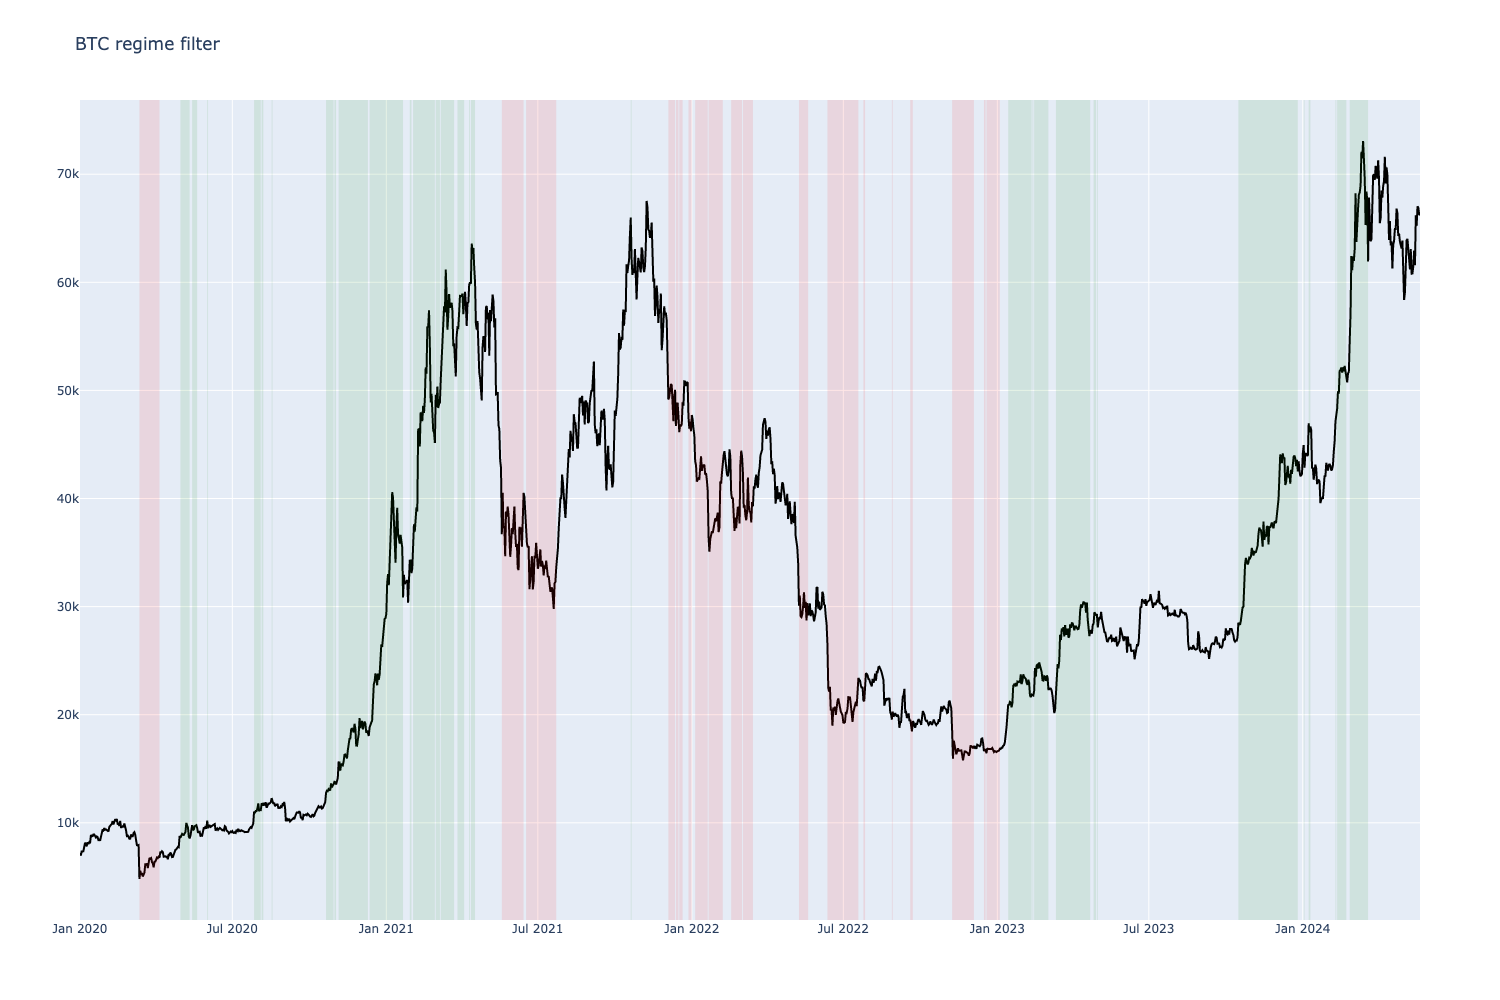

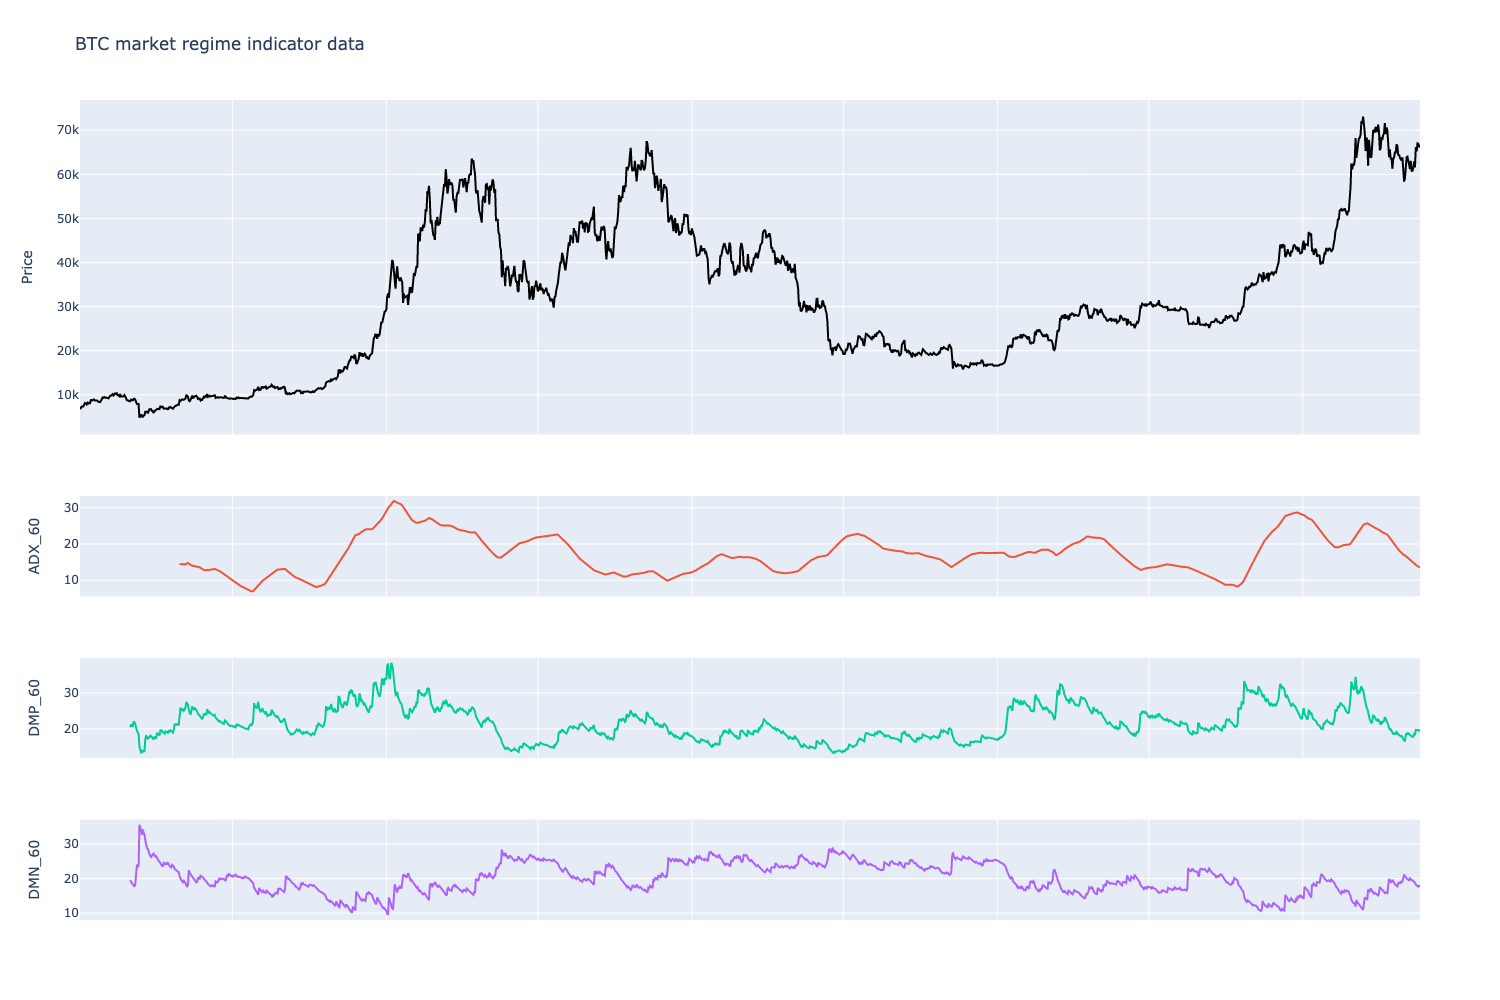

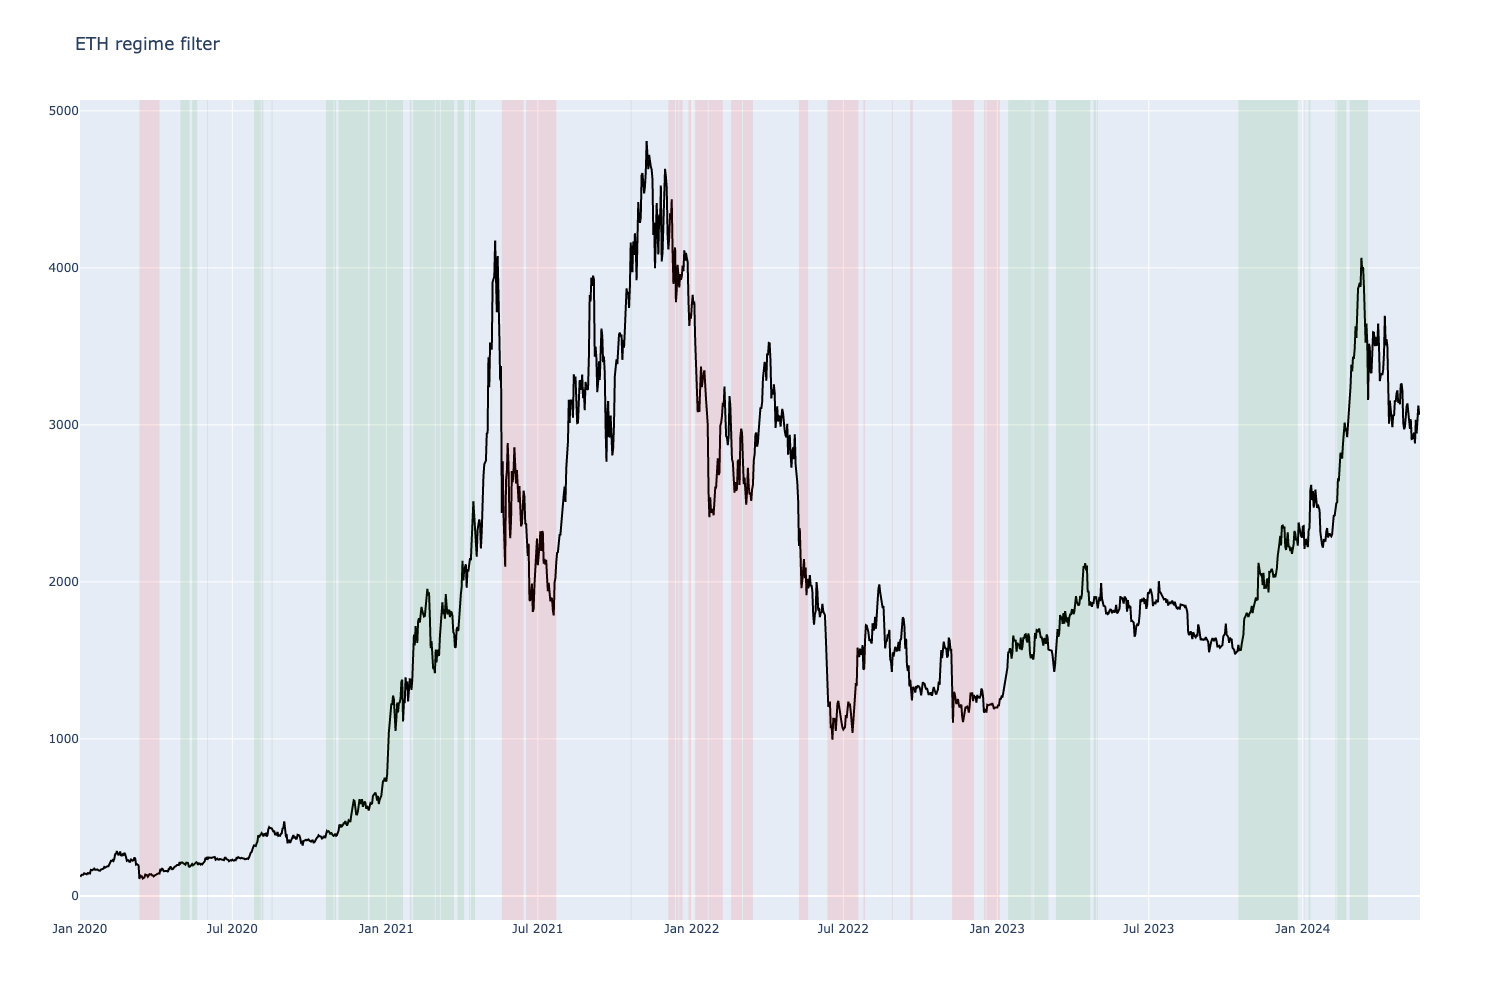

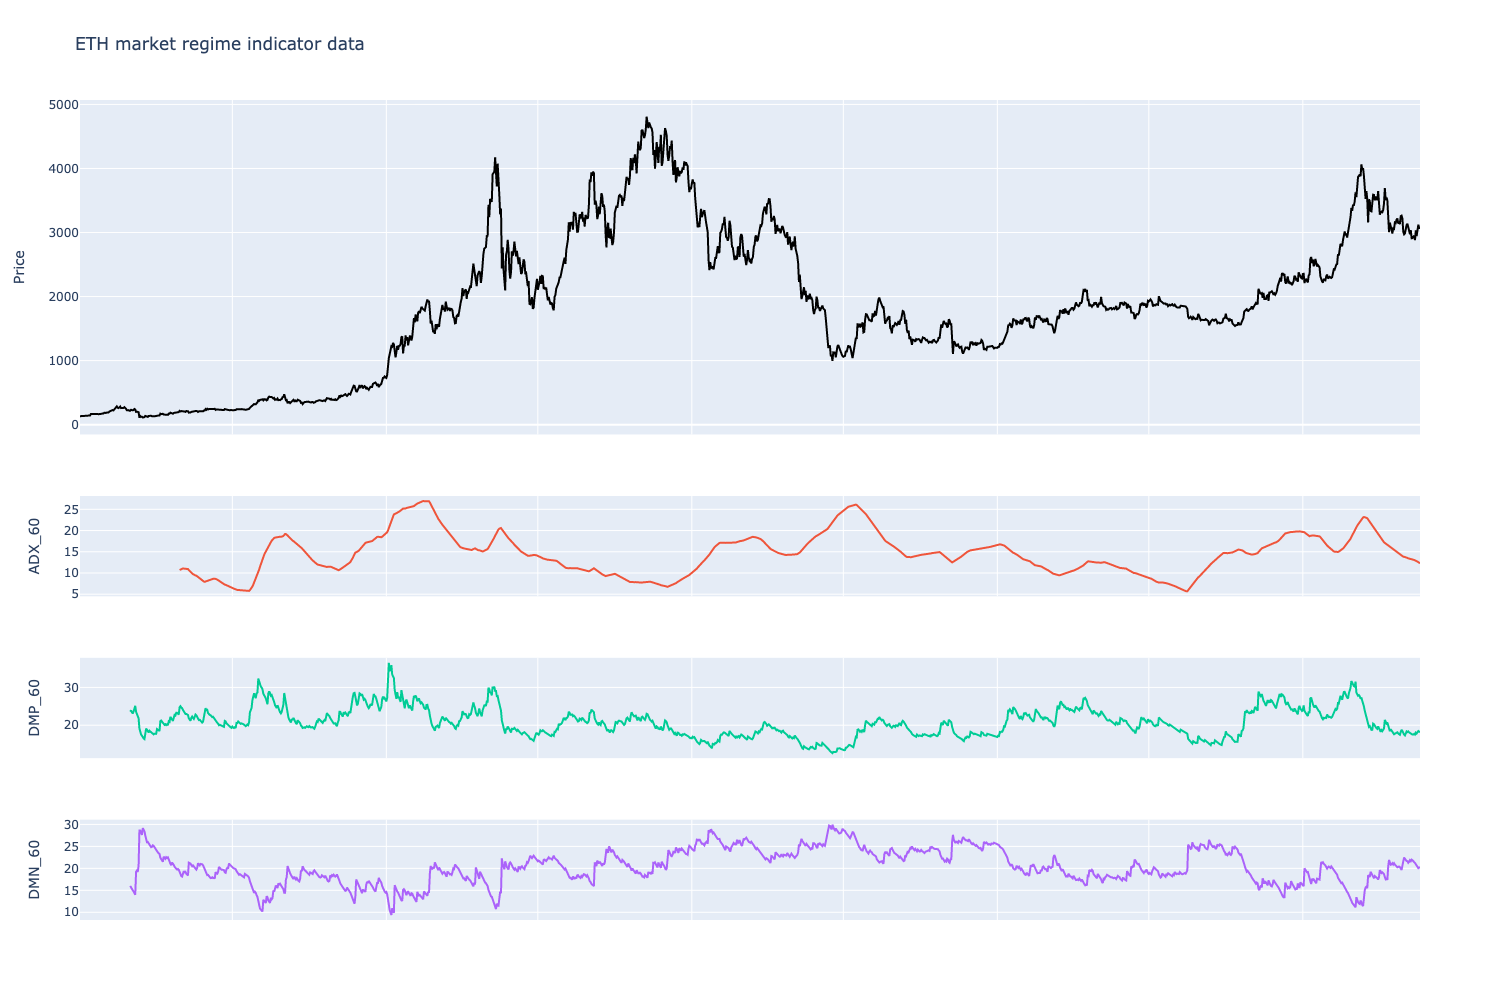

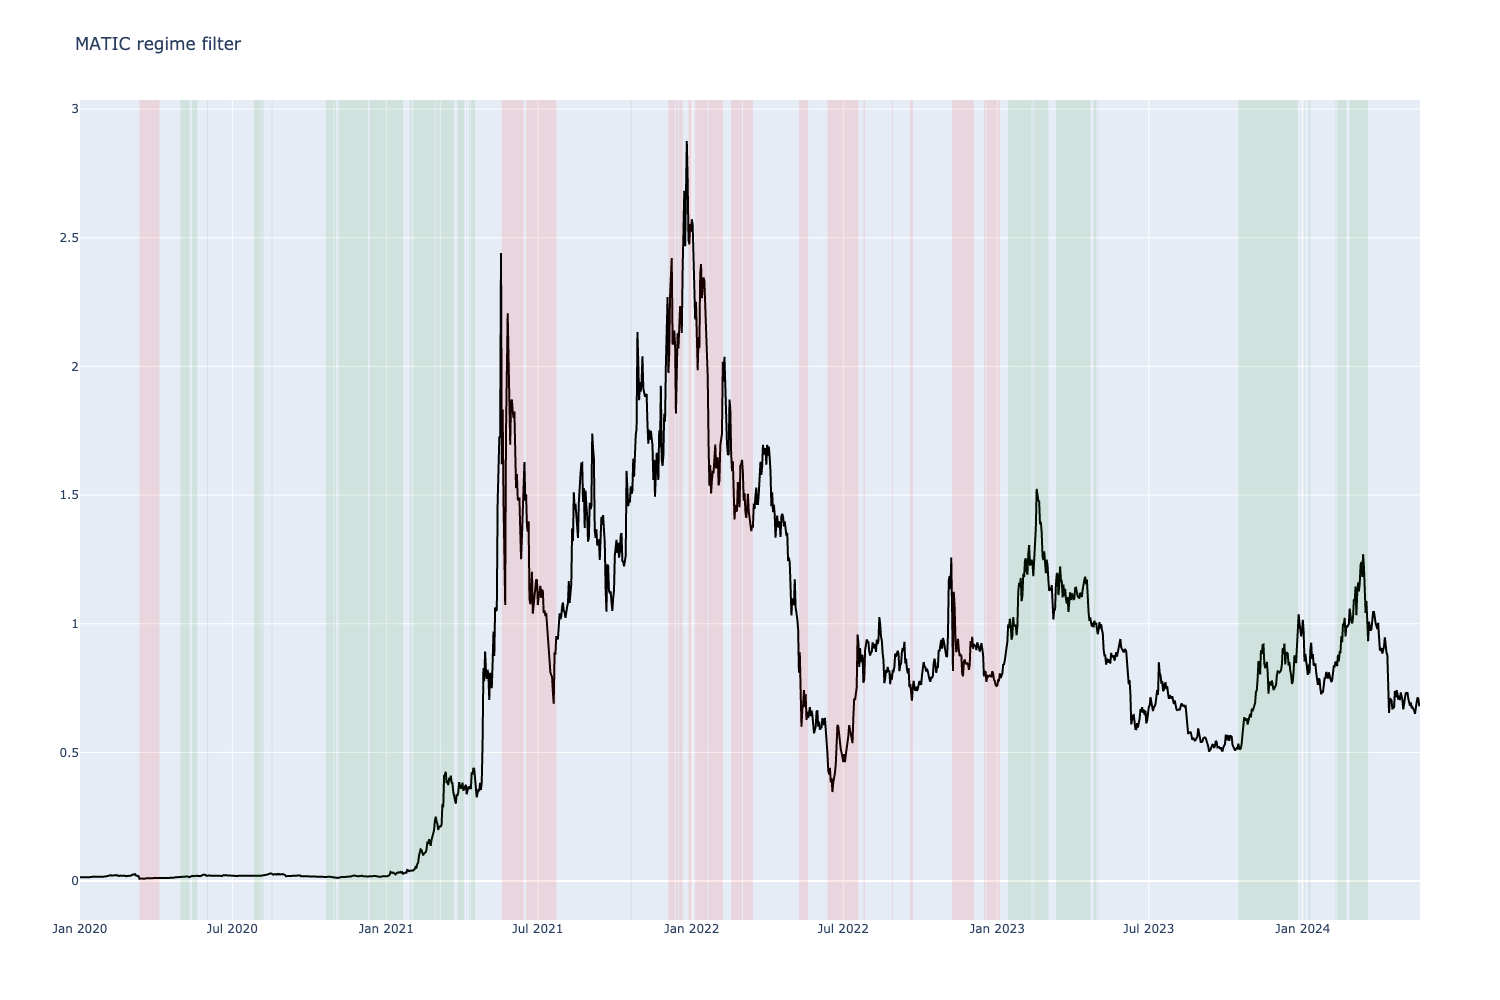

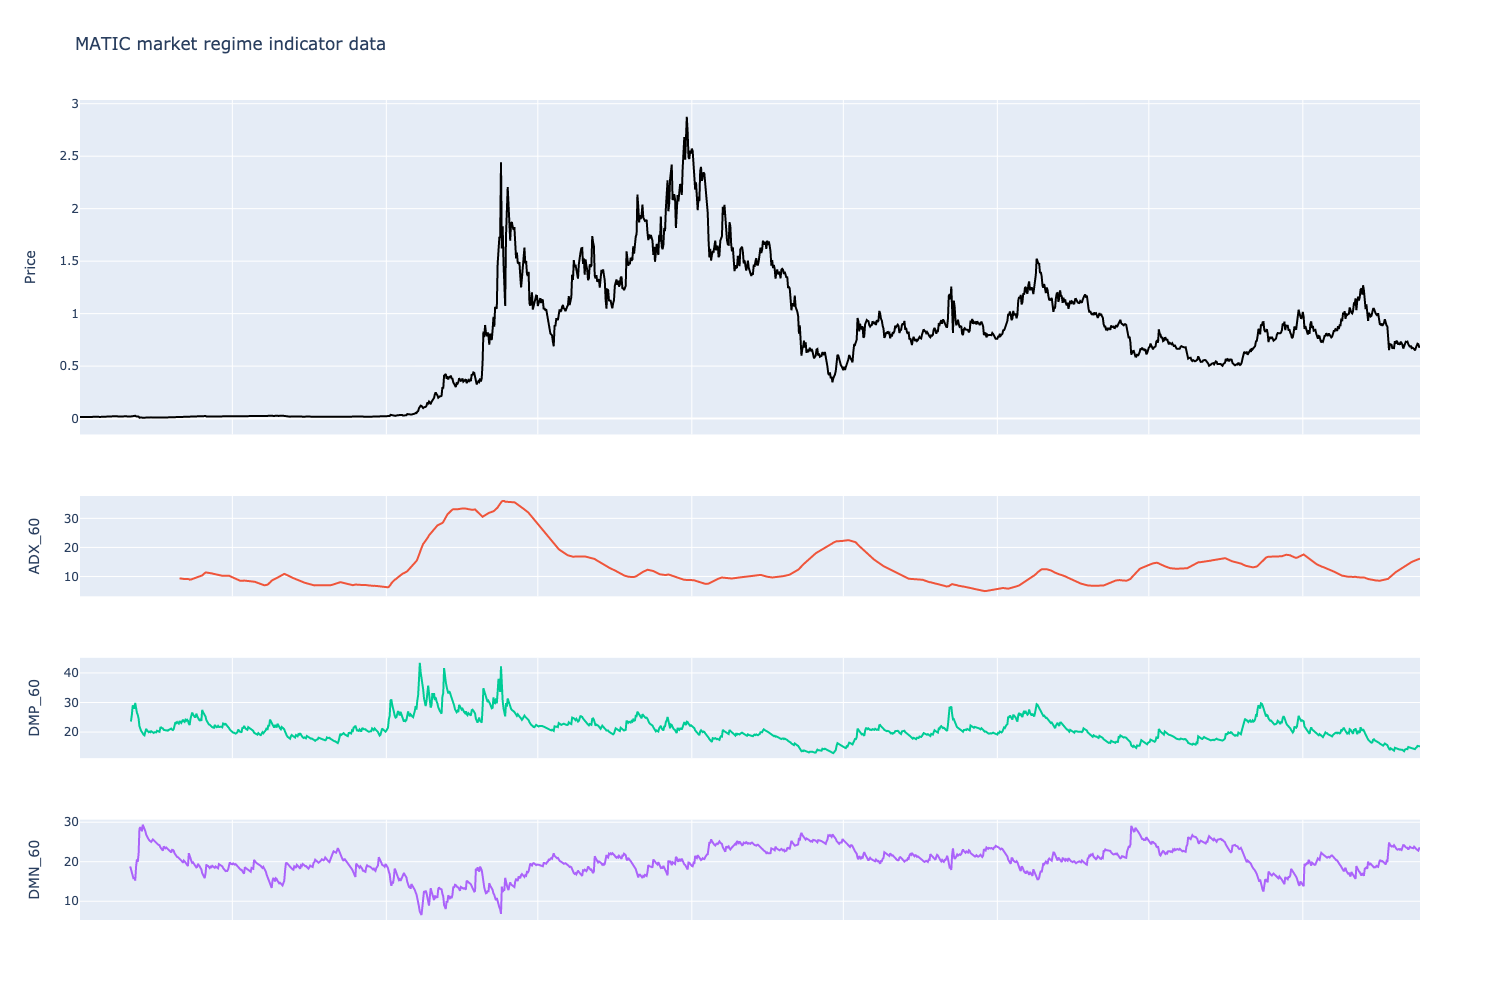

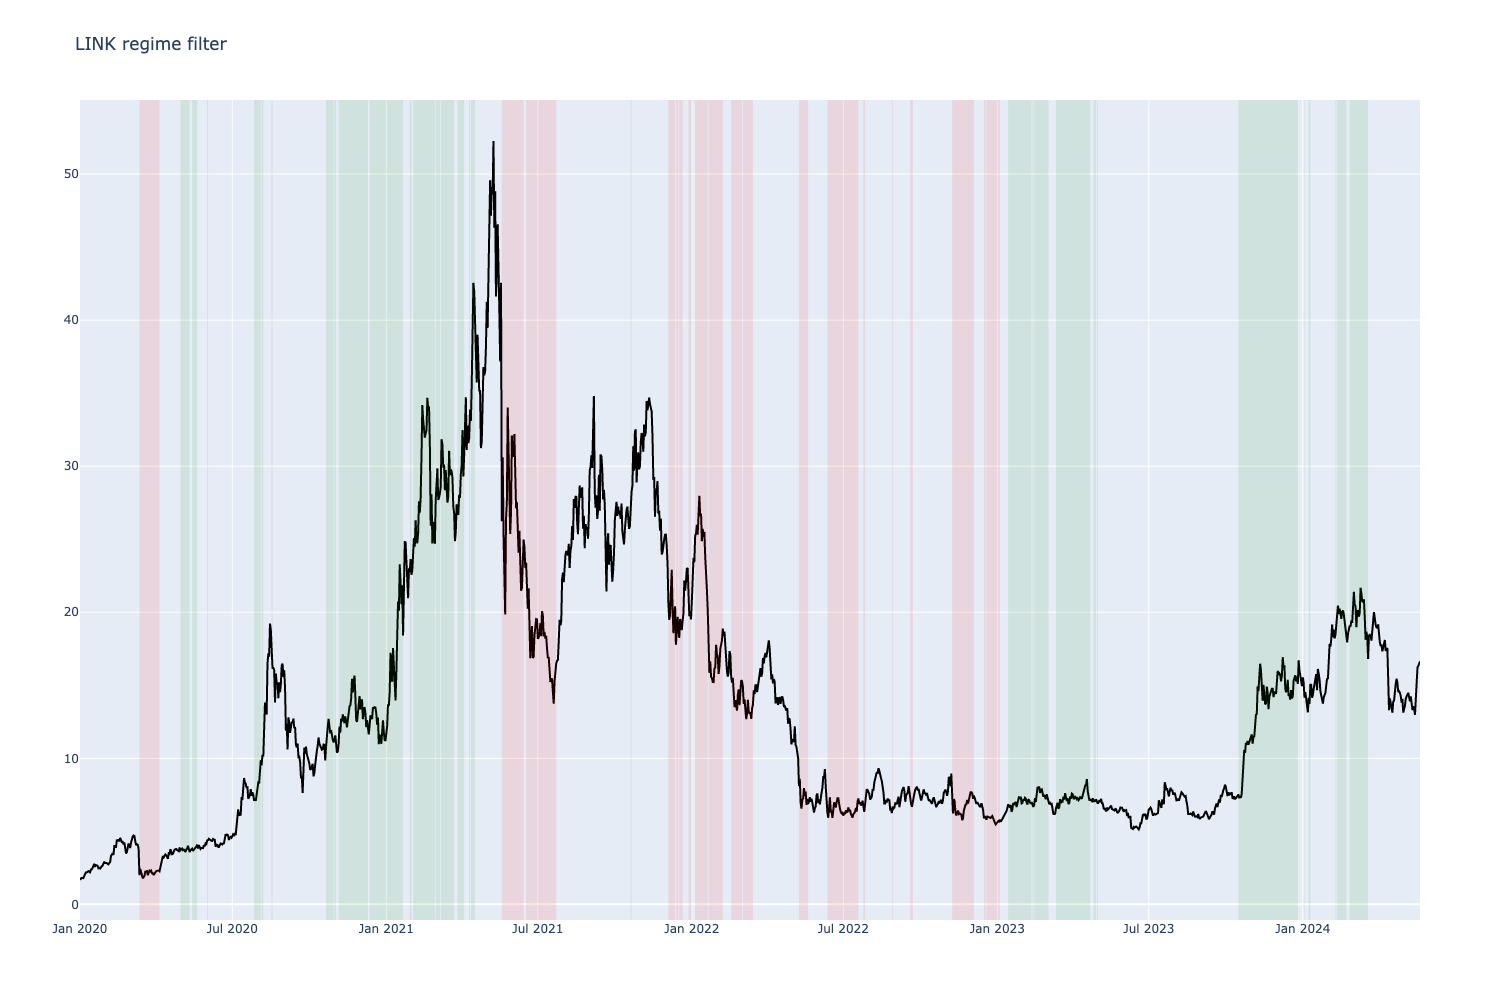

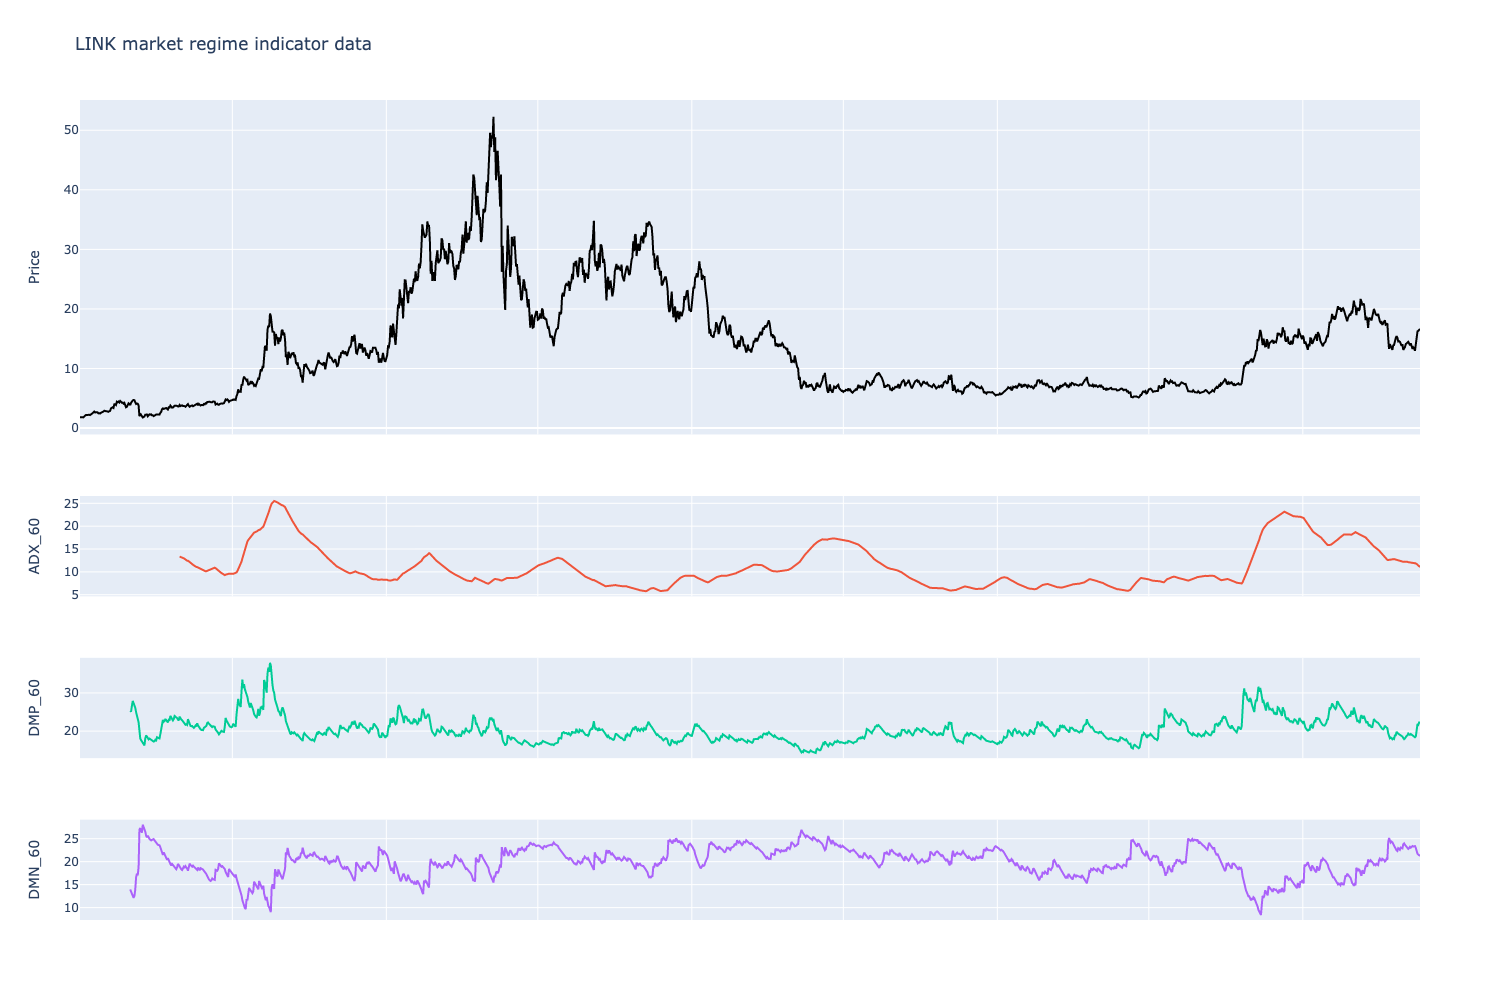

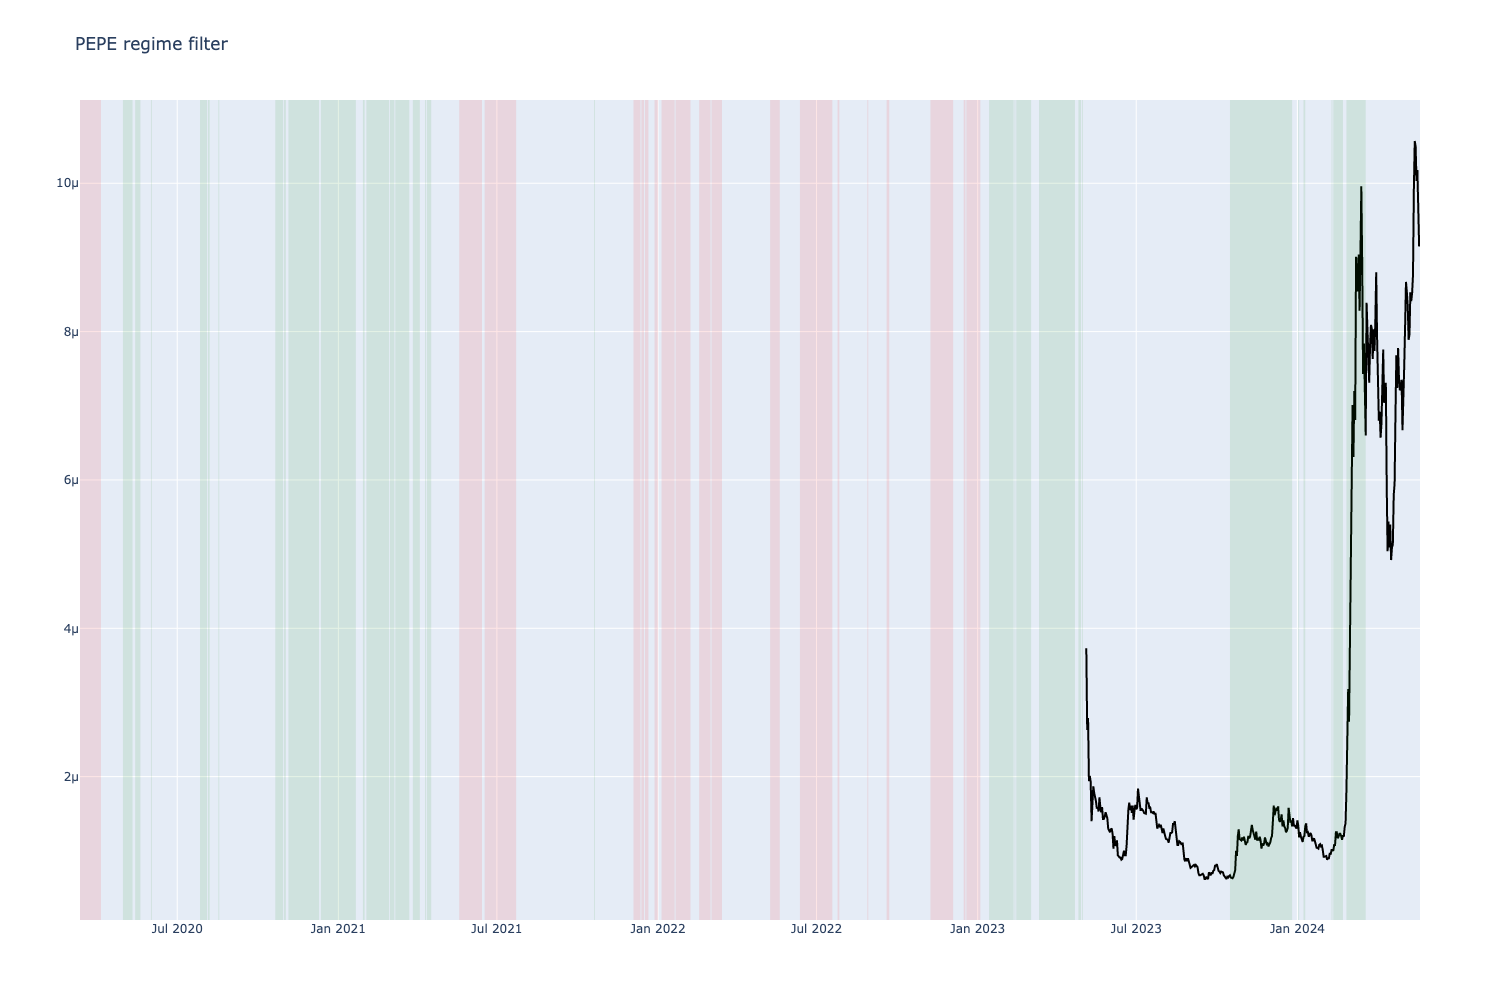

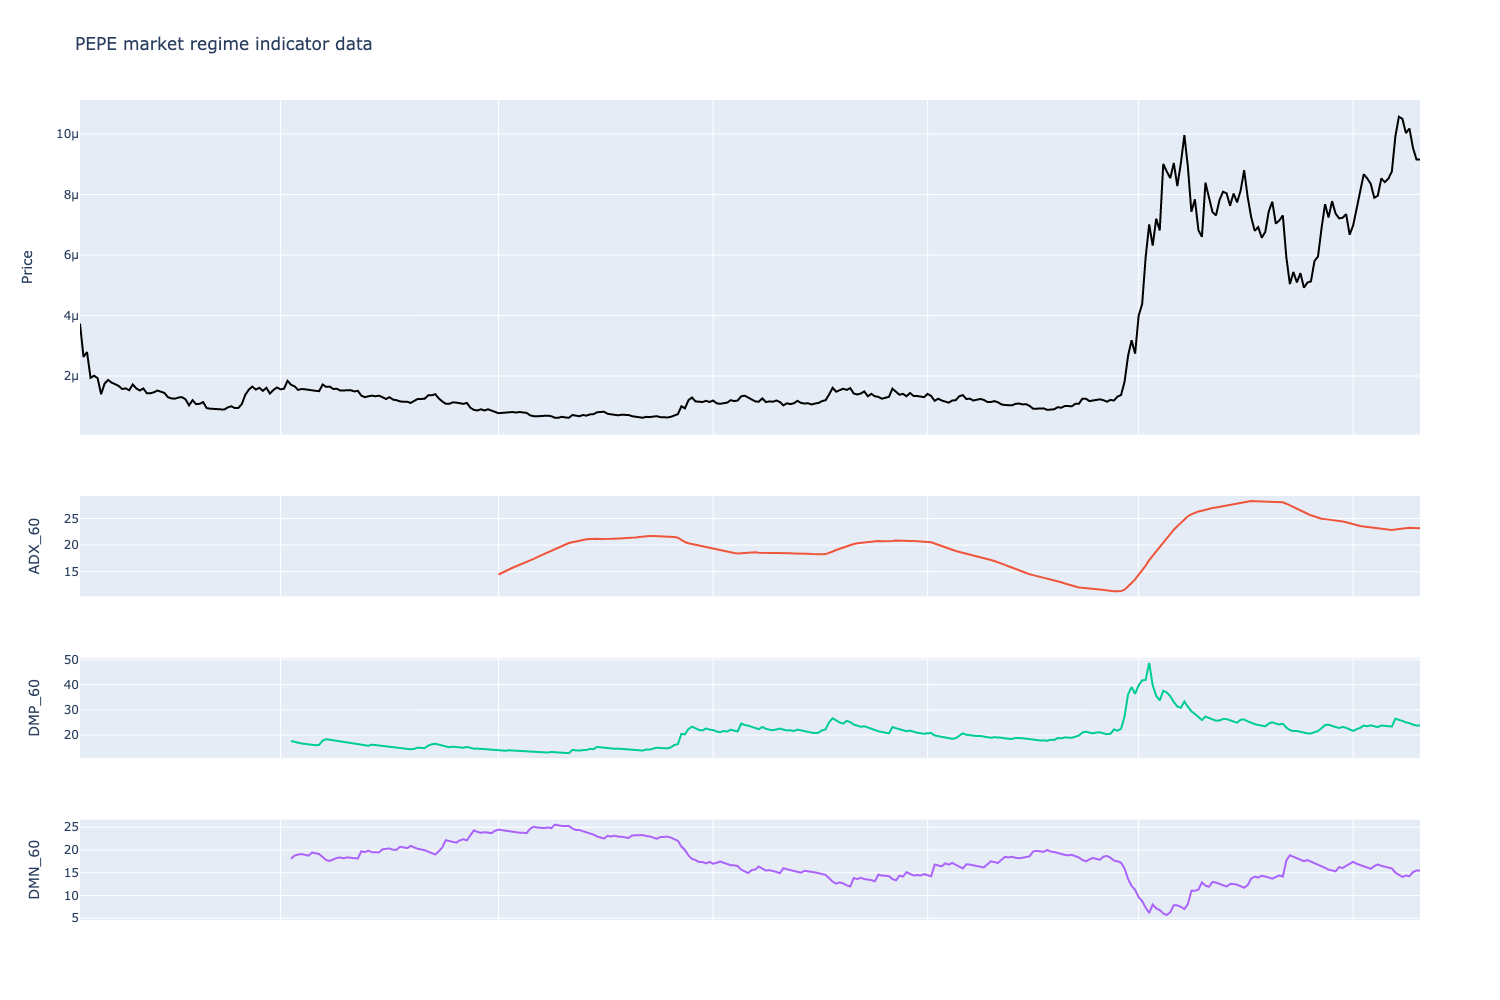

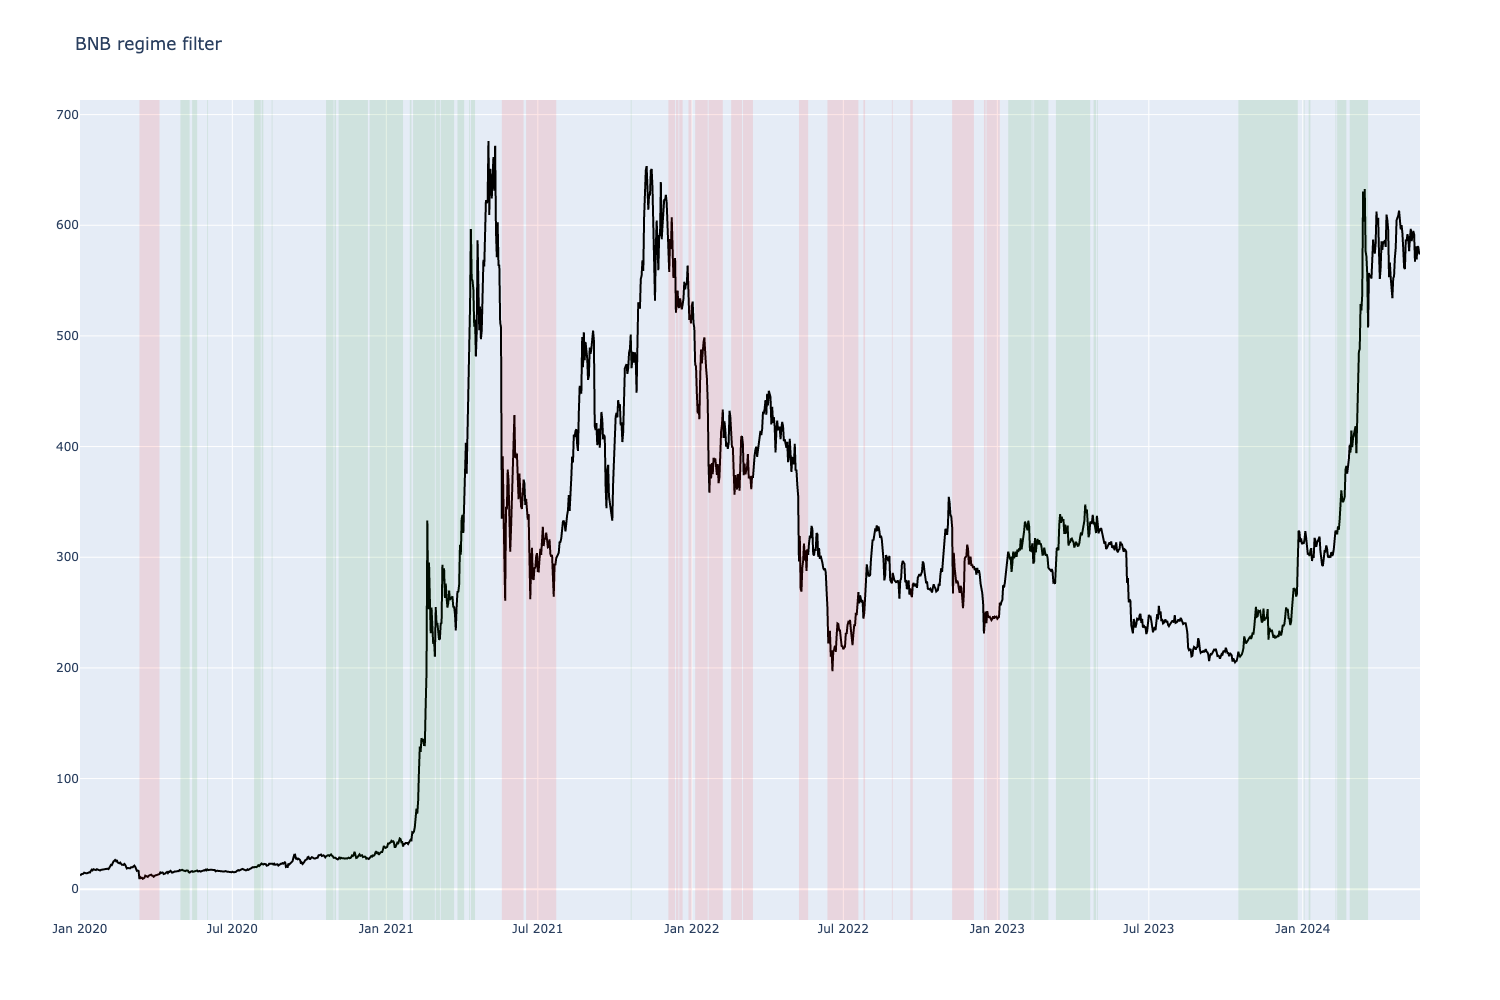

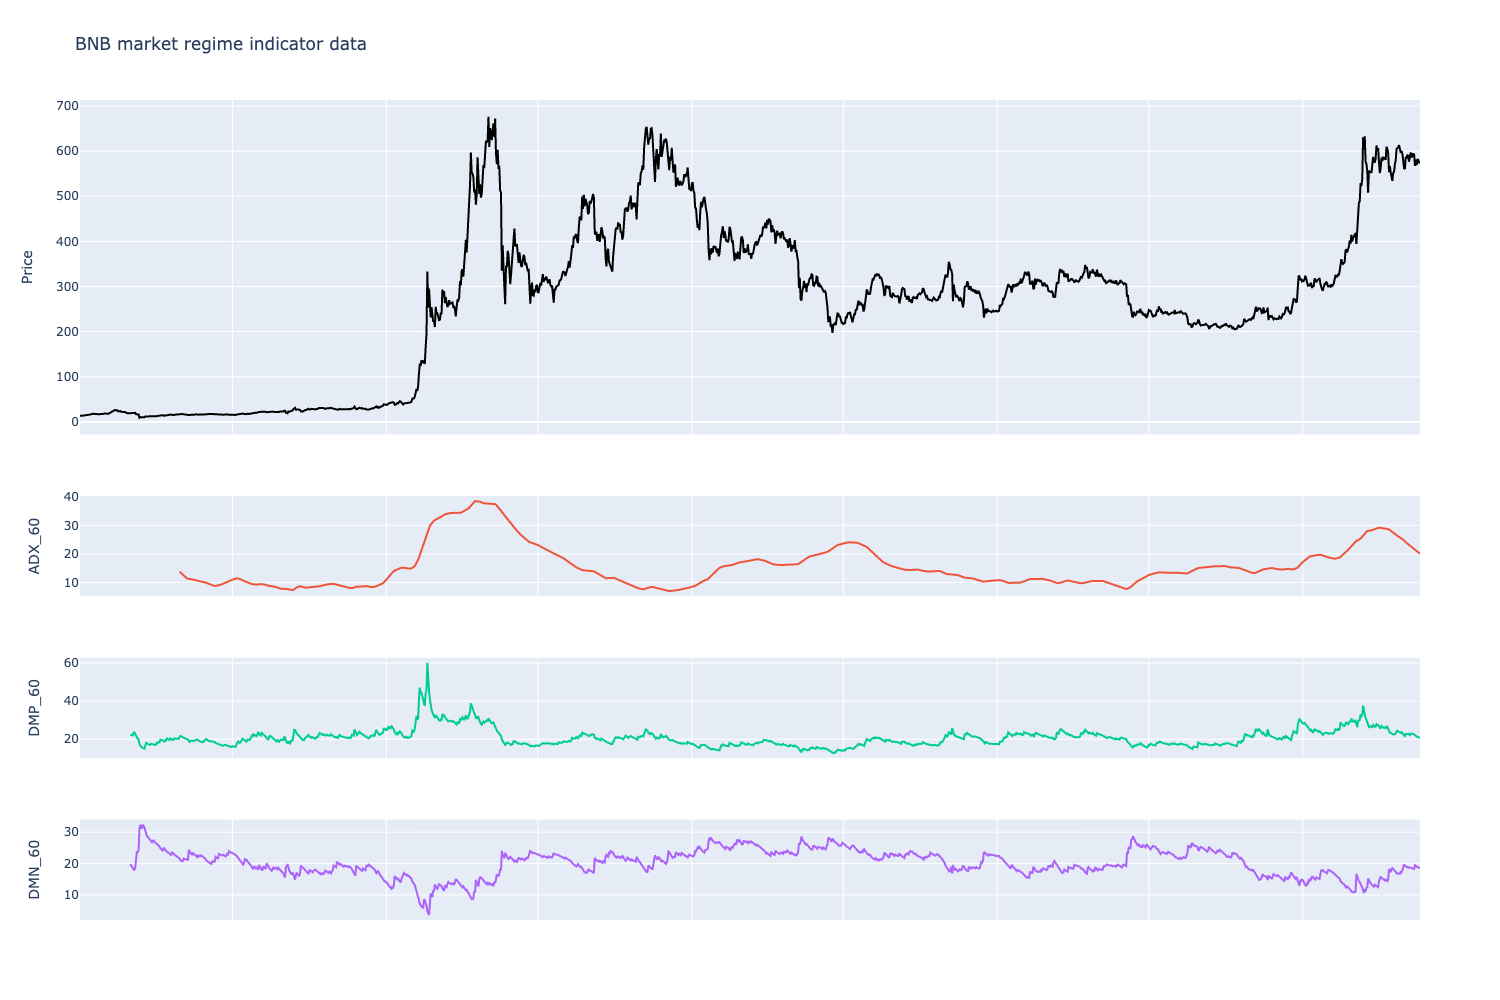

In [41]:
from tradeexecutor.visual.bullbear import visualise_market_regime_filter
from tradeexecutor.visual.bullbear import visualise_raw_market_regime_indicator

for pair_desc in trading_pairs:
    pair = strategy_universe.get_pair_by_human_description(pair_desc)

    # Pull the pair and its close price we are detecting regimes for
    daily_price = indicator_results.get_indicator_dataframe("daily_price", pair=pair)
    close_price = daily_price["close"]

    regime_signal = indicator_results.get_indicator_series("regime", pair=trading_pairs[0], unlimited=True)
    figure = visualise_market_regime_filter(
        close_price,
        regime_signal,
        title=f"{pair.base.token_symbol} regime filter"
    )
    figure.show()

    adx_df = indicator_results.get_indicator_dataframe("adx", pair=pair)
    figure = visualise_raw_market_regime_indicator(
        close_price,
        adx_df,
        height=500,
        indicator_height=150,
        title=f"{pair.base.token_symbol} market regime indicator data"
    )
    figure.show()
